In [0]:
import pyspark
from pyspark.sql import SparkSession
from pyspark.ml.feature import StringIndexer
import pandas as pd
import numpy as np
import seaborn as sns
from pyspark.ml.stat import Correlation
from matplotlib import pyplot as plt

from pyspark.sql.functions import udf
from pyspark.ml.feature import StandardScaler
from pyspark.ml.feature import MinMaxScaler
from pyspark.ml import Pipeline
from pyspark.ml.feature import VectorAssembler


from pyspark.ml.classification import LogisticRegression
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.classification import DecisionTreeClassifier
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.classification import GBTClassifier

from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
from pyspark.ml.evaluation import BinaryClassificationEvaluator

from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import plot_confusion_matrix

In [0]:
# creating a Spark Session
spark = SparkSession.builder.appName("classification").getOrCreate()

# Reading the Data from csv file
df = spark.read.csv('/FileStore/tables/EmployeeAttrition-3.csv',header=True,inferSchema=True)
df.printSchema()

root
-- Age: integer (nullable = true)
-- Attrition: string (nullable = true)
-- BusinessTravel: string (nullable = true)
-- DailyRate: integer (nullable = true)
-- Department: string (nullable = true)
-- DistanceFromHome: integer (nullable = true)
-- Education: integer (nullable = true)
-- EducationField: string (nullable = true)
-- EmployeeCount: integer (nullable = true)
-- EmployeeNumber: integer (nullable = true)
-- EnvironmentSatisfaction: integer (nullable = true)
-- Gender: string (nullable = true)
-- HourlyRate: integer (nullable = true)
-- JobInvolvement: integer (nullable = true)
-- JobLevel: integer (nullable = true)
-- JobRole: string (nullable = true)
-- JobSatisfaction: integer (nullable = true)
-- MaritalStatus: string (nullable = true)
-- MonthlyIncome: integer (nullable = true)
-- MonthlyRate: integer (nullable = true)
-- NumCompaniesWorked: integer (nullable = true)
-- Over18: string (nullable = true)
-- OverTime: string (nullable = true)
-- PercentSalaryHike: integer (nullable = true)
-- PerformanceRating: integer (nullable = true)
-- RelationshipSatisfaction: integer (nullable = true)
-- StandardHours: integer (nullable = true)
-- StockOptionLevel: integer (nullable = true)
-- TotalWorkingYears: integer (nullable = true)
-- TrainingTimesLastYear: integer (nullable = true)
-- WorkLifeBalance: integer (nullable = true)
-- YearsAtCompany: integer (nullable = true)
-- YearsInCurrentRole: integer (nullable = true)
-- YearsSinceLastPromotion: integer (nullable = true)
-- YearsWithCurrManager: integer (nullable = true)

In [0]:
# Reading the Top 5 Rows of Dataframe
df.limit(5).toPandas()

Out[5]:

,Age,Attrition,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EmployeeCount,EmployeeNumber,EnvironmentSatisfaction,Gender,HourlyRate,JobInvolvement,JobLevel,JobRole,JobSatisfaction,MaritalStatus,MonthlyIncome,MonthlyRate,NumCompaniesWorked,Over18,OverTime,PercentSalaryHike,PerformanceRating,RelationshipSatisfaction,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
0,41,Yes,Travel_Rarely,1102,Sales,1,2,Life Sciences,1,1,2,Female,94,3,2,Sales Executive,4,Single,5993,19479,8,Y,Yes,11,3,1,80,0,8,0,1,6,4,0,5
1,49,No,Travel_Frequently,279,Research & Development,8,1,Life Sciences,1,2,3,Male,61,2,2,Research Scientist,2,Married,5130,24907,1,Y,No,23,4,4,80,1,10,3,3,10,7,1,7
2,37,Yes,Travel_Rarely,1373,Research & Development,2,2,Other,1,4,4,Male,92,2,1,Laboratory Technician,3,Single,2090,2396,6,Y,Yes,15,3,2,80,0,7,3,3,0,0,0,0
3,33,No,Travel_Frequently,1392,Research & Development,3,4,Life Sciences,1,5,4,Female,56,3,1,Research Scientist,3,Married,2909,23159,1,Y,Yes,11,3,3,80,0,8,3,3,8,7,3,0
4,27,No,Travel_Rarely,591,Research & Development,2,1,Medical,1,7,1,Male,40,3,1,Laboratory Technician,2,Married,3468,16632,9,Y,No,12,3,4,80,1,6,3,3,2,2,2,2


In [0]:
# Reading the statistics of Dataframe
df.describe().toPandas()


Out[6]:

,summary,Age,Attrition,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EmployeeCount,EmployeeNumber,EnvironmentSatisfaction,Gender,HourlyRate,JobInvolvement,JobLevel,JobRole,JobSatisfaction,MaritalStatus,MonthlyIncome,MonthlyRate,NumCompaniesWorked,Over18,OverTime,PercentSalaryHike,PerformanceRating,RelationshipSatisfaction,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
0,count,1470,1470,1470,1470,1470,1470,1470,1470,1470,1470,1470,1470,1470,1470,1470,1470,1470,1470,1470,1470,1470,1470,1470,1470,1470,1470,1470,1470,1470,1470,1470,1470,1470,1470,1470
1,mean,36.923809523809524,None,None,802.4857142857143,None,9.19251700680272,2.912925170068027,None,1.0,1024.865306122449,2.721768707482993,None,65.89115646258503,2.7299319727891156,2.0639455782312925,None,2.7285714285714286,None,6502.931292517007,14313.103401360544,2.6931972789115646,None,None,15.209523809523809,3.1537414965986397,2.7122448979591836,80.0,0.7938775510204081,11.279591836734694,2.7993197278911564,2.7612244897959184,7.0081632653061225,4.229251700680272,2.1877551020408164,4.12312925170068
2,stddev,9.135373489136729,None,None,403.50909994352804,None,8.10686443566608,1.0241649445978718,None,0.0,602.0243348474752,1.0930822146350003,None,20.329427593996176,0.7115611429632297,1.1069398989351202,None,1.1028461230547213,None,4707.956783097992,7117.786044059972,2.4980090060707463,None,None,3.6599377165396385,0.36082352460434397,1.0812088864403517,0.0,0.8520766679308381,7.780781675514995,1.2892706207958466,0.7064758297141507,6.126525152403571,3.623137034670627,3.2224302791379693,3.5681361205404363
3,min,18,No,Non-Travel,102,Human Resources,1,1,Human Resources,1,1,1,Female,30,1,1,Healthcare Representative,1,Divorced,1009,2094,0,Y,No,11,3,1,80,0,0,0,1,0,0,0,0
4,max,60,Yes,Travel_Rarely,1499,Sales,29,5,Technical Degree,1,2068,4,Male,100,4,5,Sales Representative,4,Single,19999,26999,9,Y,Yes,25,4,4,80,3,40,6,4,40,18,15,17


In [0]:
# checking the null values in the dataframe
Nullvalues = {col : df.filter(df[col].isNull()).count() for col in df.columns}
Nullvalues


Out[7]: {'Age': 0,
 'Attrition': 0,
 'BusinessTravel': 0,
 'DailyRate': 0,
 'Department': 0,
 'DistanceFromHome': 0,
 'Education': 0,
 'EducationField': 0,
 'EmployeeCount': 0,
 'EmployeeNumber': 0,
 'EnvironmentSatisfaction': 0,
 'Gender': 0,
 'HourlyRate': 0,
 'JobInvolvement': 0,
 'JobLevel': 0,
 'JobRole': 0,
 'JobSatisfaction': 0,
 'MaritalStatus': 0,
 'MonthlyIncome': 0,
 'MonthlyRate': 0,
 'NumCompaniesWorked': 0,
 'Over18': 0,
 'OverTime': 0,
 'PercentSalaryHike': 0,
 'PerformanceRating': 0,
 'RelationshipSatisfaction': 0,
 'StandardHours': 0,
 'StockOptionLevel': 0,
 'TotalWorkingYears': 0,
 'TrainingTimesLastYear': 0,
 'WorkLifeBalance': 0,
 'YearsAtCompany': 0,
 'YearsInCurrentRole': 0,
 'YearsSinceLastPromotion': 0,
 'YearsWithCurrManager': 0}

Out[8]:

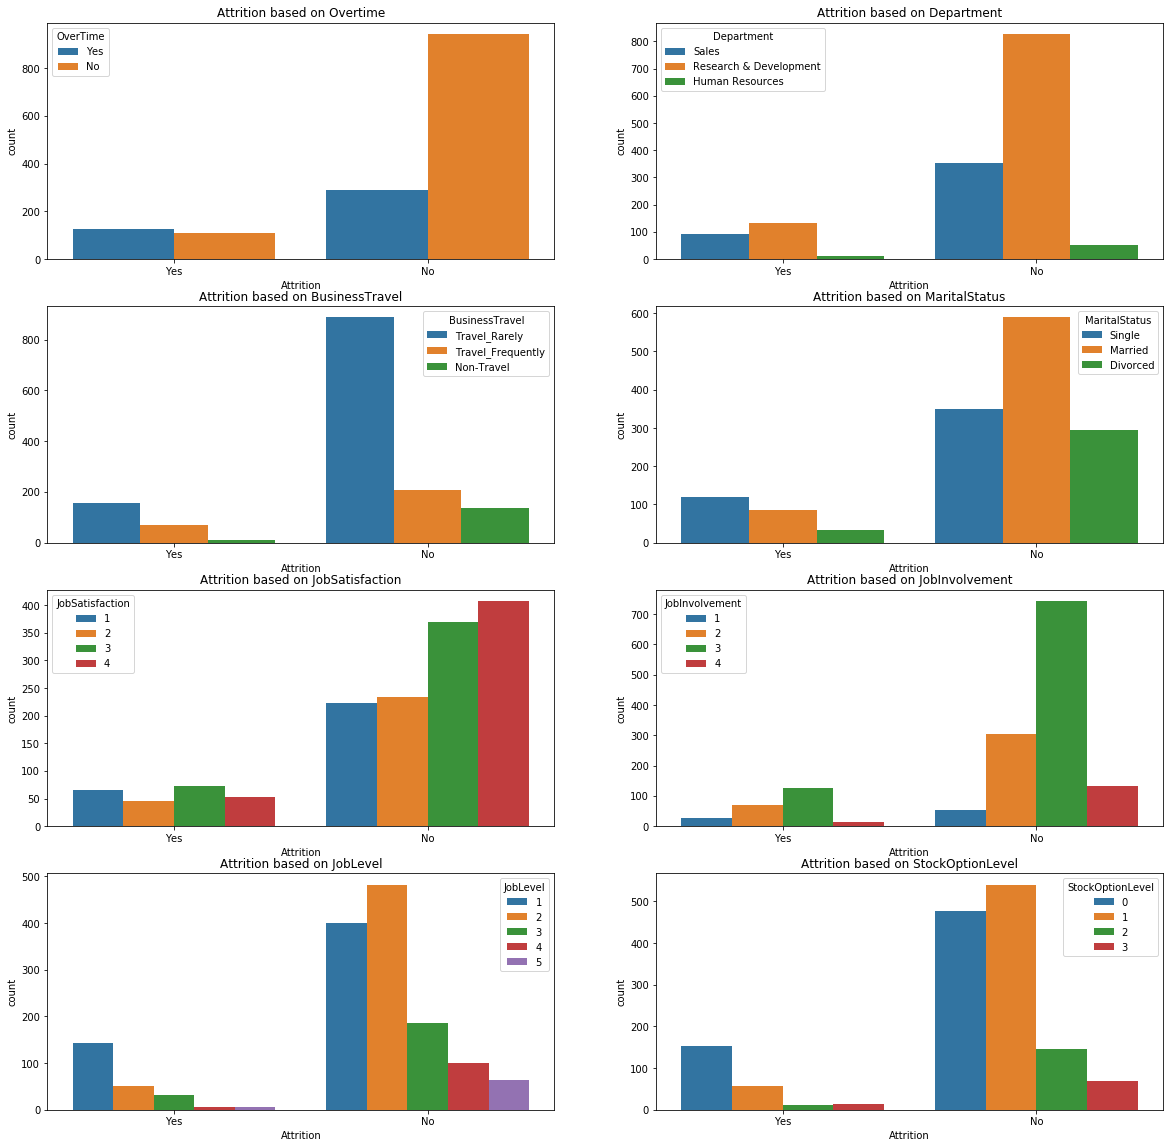

Text(0.5, 1.0, 'Attrition based on StockOptionLevel')

In [0]:
# Attrition based on  Overtime
fig,ax = plt.subplots(4,2, figsize=(20,20))
plot = sns.countplot(x="Attrition", hue="OverTime", data=df.toPandas(),ax= ax[0,0])
plot.set_title('Attrition based on Overtime')

# Attrition based on  Department
plot = sns.countplot(x="Attrition", hue="Department", data=df.toPandas(),ax= ax[0,1])
plot.set_title('Attrition based on Department')

# Attrition based on  BusinessTravel
plot = sns.countplot(x="Attrition", hue="BusinessTravel", data=df.toPandas(),ax= ax[1,0])
plot.set_title('Attrition based on BusinessTravel')

# Attrition based on  MaritalStatus
plot = sns.countplot(x="Attrition", hue="MaritalStatus", data=df.toPandas(),ax= ax[1,1])
plot.set_title('Attrition based on MaritalStatus')

# Attrition based on  JobSatisfaction
plot = sns.countplot(x="Attrition", hue="JobSatisfaction", data=df.toPandas(),ax= ax[2,0])
plot.set_title('Attrition based on JobSatisfaction')

# Attrition based on  JobInvolvement
plot = sns.countplot(x="Attrition", hue="JobInvolvement", data=df.toPandas(),ax= ax[2,1])
plot.set_title('Attrition based on JobInvolvement')

# Attrition based on  JobLevel
plot = sns.countplot(x="Attrition", hue="JobLevel", data=df.toPandas(),ax= ax[3,0])
plot.set_title('Attrition based on JobLevel')

# Attrition based on  StockOptionLevel
plot = sns.countplot(x="Attrition", hue="StockOptionLevel", data=df.toPandas(),ax= ax[3,1])
plot.set_title('Attrition based on StockOptionLevel')



Out[9]:

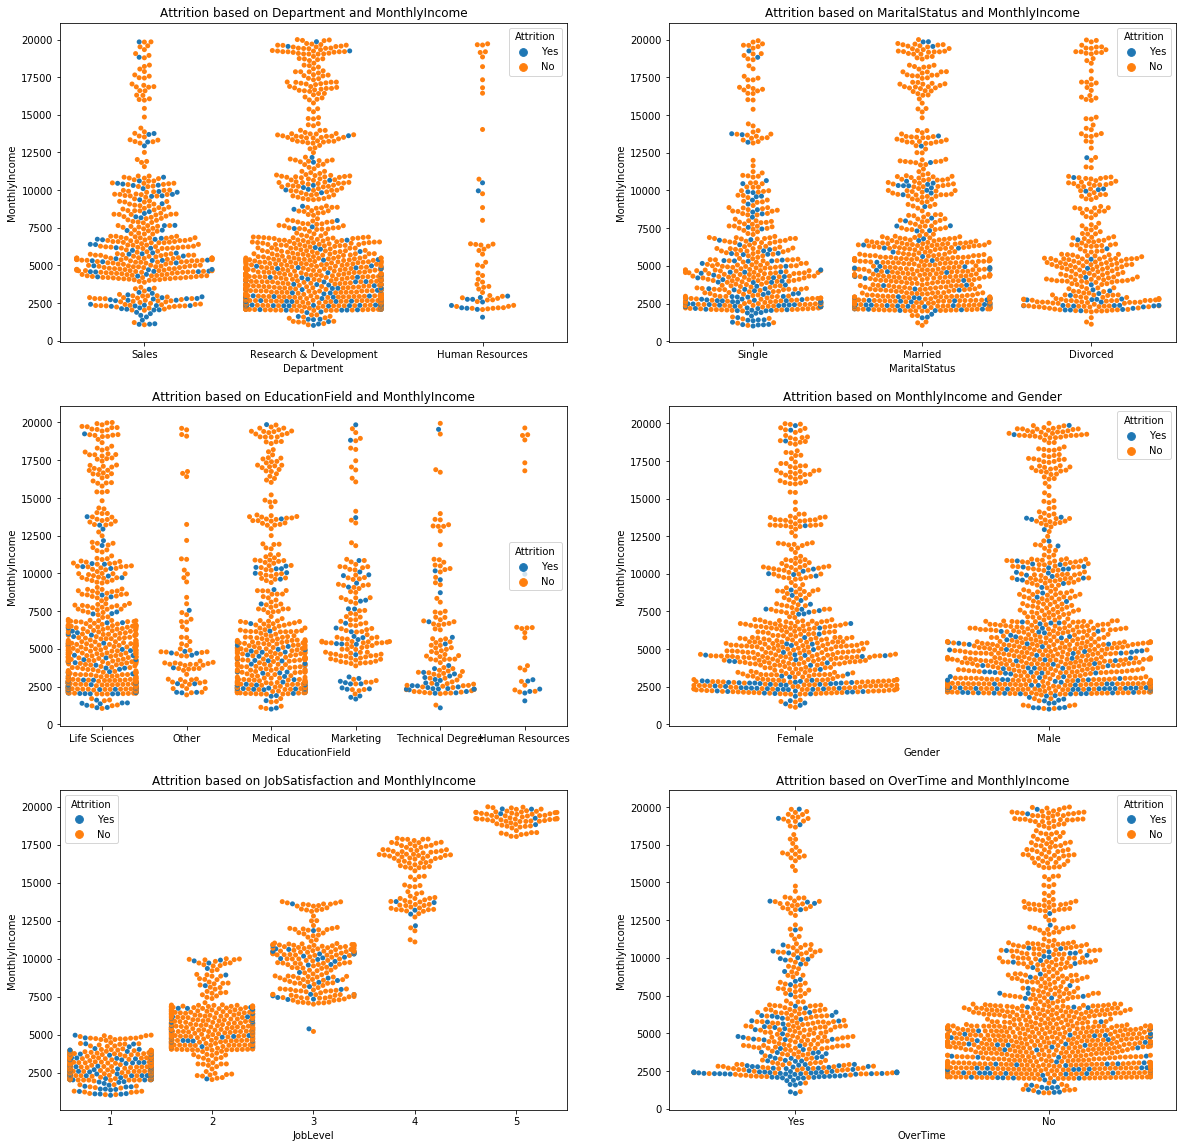

Text(0.5, 1.0, 'Attrition based on OverTime and MonthlyIncome')

In [0]:
# Plot for Continious Variables vs Categorical
fig,ax = plt.subplots(3,2, figsize=(20,20))
plot=sns.swarmplot(x="Department", y="MonthlyIncome",hue="Attrition" ,data=df.toPandas(),ax=ax[0,0]);
plot.set_title('Attrition based on Department and MonthlyIncome')

plot=sns.swarmplot(x="MaritalStatus", y="MonthlyIncome",hue="Attrition" ,data=df.toPandas(), ax=ax[0,1]);
plot.set_title('Attrition based on MaritalStatus and MonthlyIncome')

plot=sns.swarmplot(x="EducationField", y="MonthlyIncome",hue="Attrition" ,data=df.toPandas(), ax=ax[1,0]);
plot.set_title('Attrition based on EducationField and MonthlyIncome')

plot=sns.swarmplot(x="Gender", y="MonthlyIncome",hue="Attrition" ,data=df.toPandas(), ax=ax[1,1]);
plot.set_title('Attrition based on MonthlyIncome and Gender')

plot=sns.swarmplot(x="JobLevel", y="MonthlyIncome",hue="Attrition" ,data=df.toPandas(), ax=ax[2,0]);
plot.set_title('Attrition based on JobSatisfaction and MonthlyIncome')

plot=sns.swarmplot(x="OverTime", y="MonthlyIncome",hue="Attrition" ,data=df.toPandas(), ax=ax[2,1]);
plot.set_title('Attrition based on OverTime and MonthlyIncome')



Out[10]:

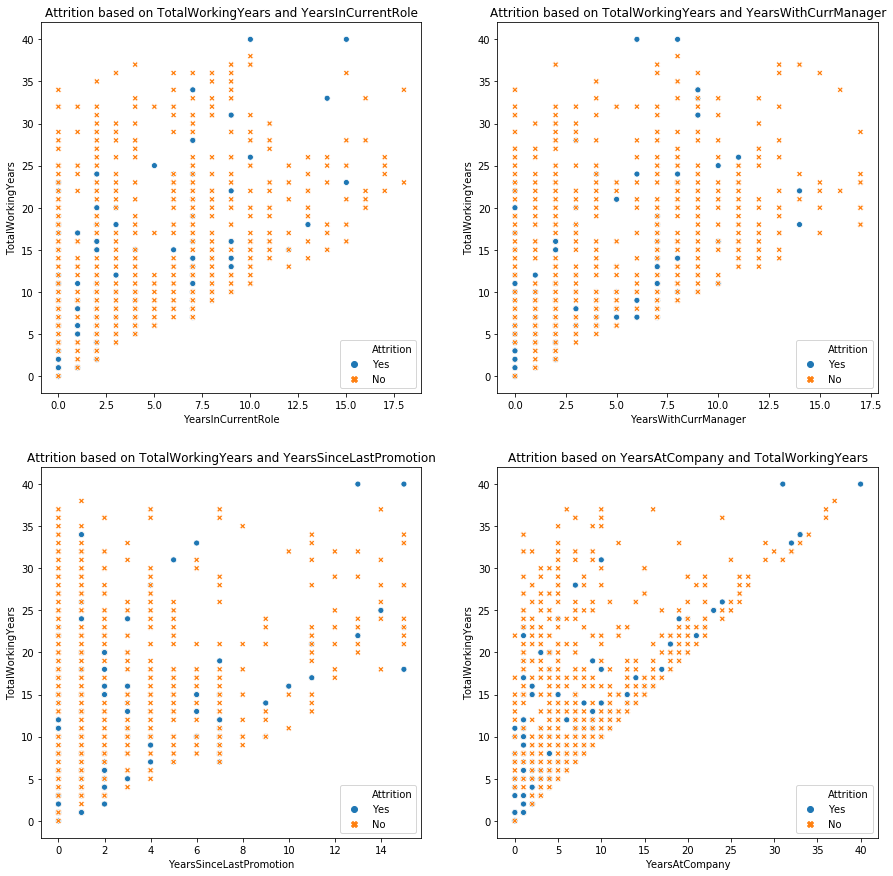

Text(0.5, 1.0, 'Attrition based on YearsAtCompany and TotalWorkingYears')

In [0]:
# Plot for Continious Variables
fig,ax = plt.subplots(2,2, figsize=(15,15))
plot = sns.scatterplot(x="YearsInCurrentRole", y="TotalWorkingYears", hue ='Attrition',style="Attrition", data=df.toPandas(),ax=ax[0,0])
plot.set_title('Attrition based on TotalWorkingYears and YearsInCurrentRole')

plot = sns.scatterplot(x="YearsWithCurrManager", y="TotalWorkingYears", hue ='Attrition',style="Attrition", data=df.toPandas(),ax=ax[0,1])
plot.set_title('Attrition based on TotalWorkingYears and YearsWithCurrManager')

plot = sns.scatterplot(x="YearsSinceLastPromotion", y="TotalWorkingYears", hue ='Attrition',style="Attrition", data=df.toPandas(),ax=ax[1,0])
plot.set_title('Attrition based on TotalWorkingYears and YearsSinceLastPromotion')

plot = sns.scatterplot(x="YearsAtCompany", y="TotalWorkingYears", hue ='Attrition',style="Attrition", data=df.toPandas(),ax=ax[1,1])
plot.set_title('Attrition based on YearsAtCompany and TotalWorkingYears')




In [0]:
# Dropping Unwanted Columns from data frame 

df = df.drop('EmployeeCount','EmployeeNumber','Over18','StandardHours')

# method to convert the categorical data into Numerical data with StringIndexer

def StringIndex(Dataframe, ColumnName):
  df = Dataframe
  column = ColumnName  
  indexer = StringIndexer(inputCol=column, outputCol= column +"Index")
  df = indexer.fit(df).transform(df)
  df = df.drop(column)
  return df


# Converting the categorical data into numerical data

categorical_list = ["Attrition","BusinessTravel", "Department","EducationField",  "Gender", "JobRole", "MaritalStatus", "OverTime"]

for column in categorical_list:
  df = StringIndex(df, column)

df.toPandas()




Out[11]:

,Age,DailyRate,DistanceFromHome,Education,EnvironmentSatisfaction,HourlyRate,JobInvolvement,JobLevel,JobSatisfaction,MonthlyIncome,MonthlyRate,NumCompaniesWorked,PercentSalaryHike,PerformanceRating,RelationshipSatisfaction,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager,AttritionIndex,BusinessTravelIndex,DepartmentIndex,EducationFieldIndex,GenderIndex,JobRoleIndex,MaritalStatusIndex,OverTimeIndex
0,41,1102,1,2,2,94,3,2,4,5993,19479,8,11,3,1,0,8,0,1,6,4,0,5,1.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0
1,49,279,8,1,3,61,2,2,2,5130,24907,1,23,4,4,1,10,3,3,10,7,1,7,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
2,37,1373,2,2,4,92,2,1,3,2090,2396,6,15,3,2,0,7,3,3,0,0,0,0,1.0,0.0,0.0,4.0,0.0,2.0,1.0,1.0
3,33,1392,3,4,4,56,3,1,3,2909,23159,1,11,3,3,0,8,3,3,8,7,3,0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0
4,27,591,2,1,1,40,3,1,2,3468,16632,9,12,3,4,1,6,3,3,2,2,2,2,0.0,0.0,0.0,1.0,0.0,2.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1465,36,884,23,2,3,41,4,2,4,2571,12290,4,17,3,3,1,17,3,3,5,2,0,3,0.0,1.0,0.0,1.0,0.0,2.0,0.0,0.0
1466,39,613,6,1,4,42,2,3,1,9991,21457,4,15,3,1,1,9,5,3,7,7,1,7,0.0,0.0,0.0,1.0,0.0,4.0,0.0,0.0
1467,27,155,4,3,2,87,4,2,2,6142,5174,1,20,4,2,1,6,0,3,6,2,0,3,0.0,0.0,0.0,0.0,0.0,3.0,0.0,1.0
1468,49,1023,2,3,4,63,2,2,2,5390,13243,2,14,3,4,0,17,3,2,9,6,0,8,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0


Out[12]:

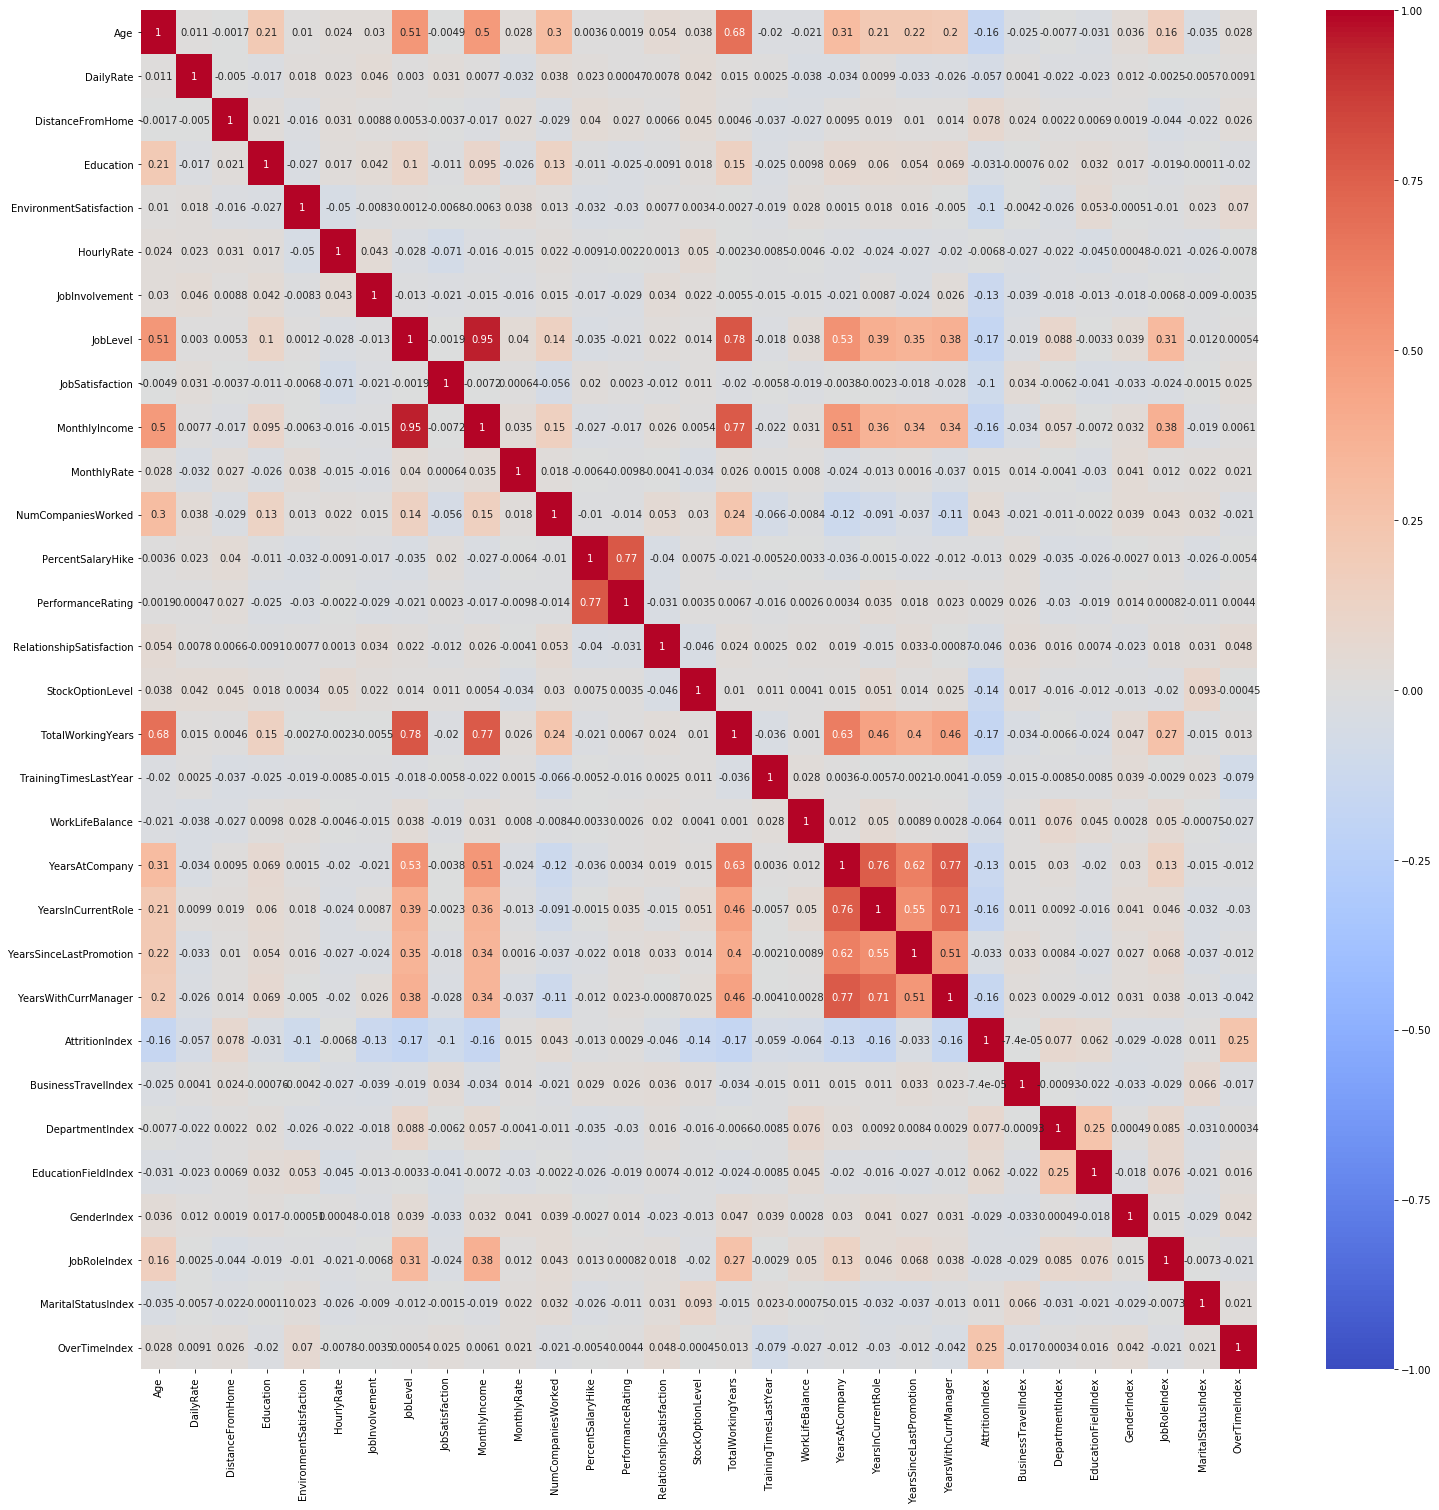

<matplotlib.axes._subplots.AxesSubplot at 0x7f2d089b85d0>

In [0]:
# Plotting the Correlation Matrix
plt.figure(figsize=(25,25))
sns.heatmap(df.toPandas().corr(method ='pearson'),  annot = True, vmin=-1, vmax=1, center= 0, cmap= 'coolwarm')

In [0]:
# Converting the string type features to Int type
from pyspark.sql.types import IntegerType
def Integer_converter(df, column):
  df = df.withColumn(column, df[column].cast(IntegerType()))
  return df 


columns =["DistanceFromHome","HourlyRate","JobSatisfaction", "MonthlyIncome", "PercentSalaryHike"]

for column in columns:
  df=Integer_converter(df, column)

In [0]:
# function to convert the features into vectors
def Vector_Assembler(columns,df):
  assembler = VectorAssembler().setInputCols(columns).setOutputCol("vectorized_features")
  df =assembler.transform(df)
  return df

columns =["Age","DailyRate", "DistanceFromHome", "Education", "EnvironmentSatisfaction", "HourlyRate", "JobInvolvement", "JobLevel", "JobSatisfaction","MonthlyIncome", "MonthlyRate", "NumCompaniesWorked","PercentSalaryHike", "PerformanceRating", "RelationshipSatisfaction","StockOptionLevel", "TotalWorkingYears", "TrainingTimesLastYear","WorkLifeBalance","YearsAtCompany","YearsInCurrentRole", "YearsSinceLastPromotion", "YearsWithCurrManager", "BusinessTravelIndex","DepartmentIndex", "EducationFieldIndex", "GenderIndex", "JobRoleIndex", "MaritalStatusIndex", "OverTimeIndex"]

df=Vector_Assembler(columns,df)
df.toPandas().head()



/databricks/spark/python/pyspark/sql/pandas/conversion.py:93: UserWarning: toPandas attempted Arrow optimization because 'spark.sql.execution.arrow.pyspark.enabled' is set to true; however, failed by the reason below:
 Unable to convert the field vectorized_features. If this column is not necessary, you may consider dropping it or converting to primitive type before the conversion.
Context: Unsupported type in conversion to Arrow: VectorUDT
Attempting non-optimization as 'spark.sql.execution.arrow.pyspark.fallback.enabled' is set to true.
 warnings.warn(msg)
Out[14]:

,Age,DailyRate,DistanceFromHome,Education,EnvironmentSatisfaction,HourlyRate,JobInvolvement,JobLevel,JobSatisfaction,MonthlyIncome,MonthlyRate,NumCompaniesWorked,PercentSalaryHike,PerformanceRating,RelationshipSatisfaction,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager,AttritionIndex,BusinessTravelIndex,DepartmentIndex,EducationFieldIndex,GenderIndex,JobRoleIndex,MaritalStatusIndex,OverTimeIndex,vectorized_features
0,41,1102,1,2,2,94,3,2,4,5993,19479,8,11,3,1,0,8,0,1,6,4,0,5,1.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,"[41.0, 1102.0, 1.0, 2.0, 2.0, 94.0, 3.0, 2.0, ..."
1,49,279,8,1,3,61,2,2,2,5130,24907,1,23,4,4,1,10,3,3,10,7,1,7,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,"[49.0, 279.0, 8.0, 1.0, 3.0, 61.0, 2.0, 2.0, 2..."
2,37,1373,2,2,4,92,2,1,3,2090,2396,6,15,3,2,0,7,3,3,0,0,0,0,1.0,0.0,0.0,4.0,0.0,2.0,1.0,1.0,"[37.0, 1373.0, 2.0, 2.0, 4.0, 92.0, 2.0, 1.0, ..."
3,33,1392,3,4,4,56,3,1,3,2909,23159,1,11,3,3,0,8,3,3,8,7,3,0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,"[33.0, 1392.0, 3.0, 4.0, 4.0, 56.0, 3.0, 1.0, ..."
4,27,591,2,1,1,40,3,1,2,3468,16632,9,12,3,4,1,6,3,3,2,2,2,2,0.0,0.0,0.0,1.0,0.0,2.0,0.0,0.0,"[27.0, 591.0, 2.0, 1.0, 1.0, 40.0, 3.0, 1.0, 2..."


In [0]:
# Scaling the features so that all features are at same scale
def StandardSclar(df):
  scaler = StandardScaler().setInputCol ("vectorized_features").setOutputCol ("features")       
  scaler_model=scaler.fit(df)
  df=scaler_model.transform(df)
  df = df.drop("vectorized_features")
  return df
df = StandardSclar(df)


/databricks/spark/python/pyspark/sql/pandas/conversion.py:93: UserWarning: toPandas attempted Arrow optimization because 'spark.sql.execution.arrow.pyspark.enabled' is set to true; however, failed by the reason below:
 Unable to convert the field features. If this column is not necessary, you may consider dropping it or converting to primitive type before the conversion.
Context: Unsupported type in conversion to Arrow: VectorUDT
Attempting non-optimization as 'spark.sql.execution.arrow.pyspark.fallback.enabled' is set to true.
 warnings.warn(msg)
Out[15]:

,features
0,"[4.488048578282528, 2.7310412581878016, 0.1233..."
1,"[5.363765374044972, 0.6914342205393799, 0.9868..."
2,"[4.050190180401305, 3.4026494078873424, 0.2467..."
3,"[3.612331782520083, 3.44973632613196, 0.370056..."
4,"[2.95554418569825, 1.464650983293095, 0.246704..."


In [0]:
df.toPandas().head()

/databricks/spark/python/pyspark/sql/pandas/conversion.py:93: UserWarning: toPandas attempted Arrow optimization because 'spark.sql.execution.arrow.pyspark.enabled' is set to true; however, failed by the reason below:
 Unable to convert the field features. If this column is not necessary, you may consider dropping it or converting to primitive type before the conversion.
Context: Unsupported type in conversion to Arrow: VectorUDT
Attempting non-optimization as 'spark.sql.execution.arrow.pyspark.fallback.enabled' is set to true.
 warnings.warn(msg)
Out[16]:

,Age,DailyRate,DistanceFromHome,Education,EnvironmentSatisfaction,HourlyRate,JobInvolvement,JobLevel,JobSatisfaction,MonthlyIncome,MonthlyRate,NumCompaniesWorked,PercentSalaryHike,PerformanceRating,RelationshipSatisfaction,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager,AttritionIndex,BusinessTravelIndex,DepartmentIndex,EducationFieldIndex,GenderIndex,JobRoleIndex,MaritalStatusIndex,OverTimeIndex,features
0,41,1102,1,2,2,94,3,2,4,5993,19479,8,11,3,1,0,8,0,1,6,4,0,5,1.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,"[4.488048578282528, 2.7310412581878016, 0.1233..."
1,49,279,8,1,3,61,2,2,2,5130,24907,1,23,4,4,1,10,3,3,10,7,1,7,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,"[5.363765374044972, 0.6914342205393799, 0.9868..."
2,37,1373,2,2,4,92,2,1,3,2090,2396,6,15,3,2,0,7,3,3,0,0,0,0,1.0,0.0,0.0,4.0,0.0,2.0,1.0,1.0,"[4.050190180401305, 3.4026494078873424, 0.2467..."
3,33,1392,3,4,4,56,3,1,3,2909,23159,1,11,3,3,0,8,3,3,8,7,3,0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,"[3.612331782520083, 3.44973632613196, 0.370056..."
4,27,591,2,1,1,40,3,1,2,3468,16632,9,12,3,4,1,6,3,3,2,2,2,2,0.0,0.0,0.0,1.0,0.0,2.0,0.0,0.0,"[2.95554418569825, 1.464650983293095, 0.246704..."


In [0]:
# splitting data for Model Training and Model Testing
train, test = df.randomSplit([0.7, 0.3], seed = 2020)
print("Training Dataset Count: " + str(train.count()))
print("Test Dataset Count: " + str(test.count()))


Training Dataset Count: 1060
Test Dataset Count: 410

In [0]:
# Displaying the train and test data groupby Attrition index
train.groupby("AttritionIndex").count().show()
test.groupby("AttritionIndex").count().show()

+--------------+-----+
AttritionIndex|count|
+--------------+-----+
 0.0| 881|
 1.0| 179|
+--------------+-----+

+--------------+-----+
AttritionIndex|count|
+--------------+-----+
 0.0| 352|
 1.0| 58|
+--------------+-----+

In [0]:
multi_evaluator=MulticlassClassificationEvaluator(labelCol="AttritionIndex", predictionCol="prediction", metricName="accuracy")

# Logistic Regression
lr = LogisticRegression(featuresCol = 'features', labelCol = 'AttritionIndex')
lrModel = lr.fit(train)

# Prediction with train data
lr_predictions_train = lrModel.transform(train)

# Prediction with test data
lr_predictions_test = lrModel.transform(test)
# lr_predictions.select('AttritionIndex', 'features',  'rawPrediction', 'prediction', 'probability').toPandas().head(5)

# calculating the Accuracy 
print('Logistic Regression classifier Accuracy Train:', multi_evaluator.evaluate(lr_predictions_train))
print('Logistic Regression classifier Accuracy Test:', multi_evaluator.evaluate(lr_predictions_test))

# Saving the Acuracy Values
Logistic_accuracy_without_cv_train = multi_evaluator.evaluate(lr_predictions_train)
Logistic_accuracy_without_cv_test = multi_evaluator.evaluate(lr_predictions_test)


Logistic Regression classifier Accuracy Train: 0.8820754716981132
Logistic Regression classifier Accuracy Test: 0.875609756097561

In [0]:
# Decision Tree Classifier
dt = DecisionTreeClassifier(featuresCol = 'features', labelCol = 'AttritionIndex', maxDepth = 3)
dtModel = dt.fit(train)

# Prediction with train data
dt_predictions_train = dtModel.transform(train)

# Prediction with test data
dt_predictions_test = dtModel.transform(test)

# calculating the Accuracy 
print('Decision tree classifier Accuracy Train:', multi_evaluator.evaluate(dt_predictions_train))
print('Decision tree classifier Accuracy Test:', multi_evaluator.evaluate(dt_predictions_test))
# Saving the Acuracy Values
DecisionTree_accuracy_without_cv_train = multi_evaluator.evaluate(dt_predictions_train)
DecisionTree_accuracy_without_cv_test = multi_evaluator.evaluate(dt_predictions_test)



Decision tree classifier Accuracy Train: 0.8594339622641509
Decision tree classifier Accuracy Test: 0.8414634146341463

In [0]:
# Random Forest Classifier
rf = RandomForestClassifier(labelCol='AttritionIndex', 
                            featuresCol='features',
                            maxDepth=5)
# Fit the model
rfmodel = rf.fit(train)

# Prediction with train data
rf_predictions_train = rfmodel.transform(train)

# Prediction with test data
rf_predictions_test = rfmodel.transform(test)

# calculating the Accuracy 
print('Random Forest classifier Accuracy Train:', multi_evaluator.evaluate(rf_predictions_train))
print('Random Forest classifier Accuracy Test:', multi_evaluator.evaluate(rf_predictions_test))

# Saving the Acuracy Values
RandomForest_accuracy_without_cv_train = multi_evaluator.evaluate(rf_predictions_train)
RandomForest_accuracy_without_cv_test = multi_evaluator.evaluate(rf_predictions_test)


Random Forest classifier Accuracy Train: 0.8735849056603774
Random Forest classifier Accuracy Test: 0.8609756097560975

In [0]:

# Gradient Boosting Tree Classifier
gbt = GBTClassifier(featuresCol = 'features', labelCol = 'AttritionIndex')
gbtModel = gbt.fit(train)

# Prediction with train data
gbt_predictions_train = gbtModel.transform(train)

# Prediction with test data
gbt_predictions_test = gbtModel.transform(test)

# calculating the Accuracy 
print('Gradinet Boosting classifier Accuracy Train:', multi_evaluator.evaluate(gbt_predictions_train))
print('Gradinet Boosting classifier Accuracy Test:', multi_evaluator.evaluate(gbt_predictions_test))

# Saving the Acuracy Values
GBT_accuracy_without_cv_train = multi_evaluator.evaluate(gbt_predictions_train)
GBT_accuracy_without_cv_test = multi_evaluator.evaluate(gbt_predictions_test)

Gradinet Boosting classifier Accuracy Train: 0.970754716981132
Gradinet Boosting classifier Accuracy Test: 0.8463414634146341

In [0]:
# model Evaluator
evaluator=BinaryClassificationEvaluator(rawPredictionCol='rawPrediction',labelCol='AttritionIndex')
evaluator1=BinaryClassificationEvaluator(rawPredictionCol="rawPrediction", labelCol='AttritionIndex',metricName = "areaUnderPR")

In [0]:
# Logistic Regression

#Logistic regression Model
lr = LogisticRegression(featuresCol = 'features', labelCol = 'AttritionIndex')
# Building ParamGrid
paramGrid = (ParamGridBuilder()
             .addGrid(lr.regParam, [0,0.5,1.0,2.0])
             .addGrid(lr.elasticNetParam, [0,0.25,0.5,0.75])
             .addGrid(lr.maxIter, [ 100,200,300])
             .build())
  
# Create 5-fold CrossValidator
cv = CrossValidator(estimator=lr, estimatorParamMaps=paramGrid, evaluator=evaluator, numFolds=5,parallelism=5)    

# Run cross validations
lr_cvModel = cv.fit(train)

lr_cvModel_predict_train=lr_cvModel.transform(train)
lr_cvModel_predict_test=lr_cvModel.transform(test)

# calculating the Accuracy 
print('Logistic Regression classifier Accuracy Train:', multi_evaluator.evaluate(lr_cvModel_predict_train))
print('Logistic Regression classifier Accuracy Test:', multi_evaluator.evaluate(lr_cvModel_predict_test))

# Saving Accuracy Scores
LogisticRegression_Accuracy_Test = multi_evaluator.evaluate(lr_cvModel_predict_train)
LogisticRegression_Accuracy_Train = multi_evaluator.evaluate(lr_cvModel_predict_test)

Logistic Regression classifier Accuracy Train: 0.8820754716981132
Logistic Regression classifier Accuracy Test: 0.875609756097561

In [0]:
# print(lr_cvModel.bestModel._java_obj.getElasticNetParam())
# print(lr_cvModel.bestModel._java_obj.getRegParam())
# print(lr_cvModel.bestModel._java_obj.getMaxIter())

# Best Params
Logistic_Regression_Bestparams = {"ElasticNetParam":lr_cvModel.bestModel._java_obj.getElasticNetParam(),
                                 "RegParam":lr_cvModel.bestModel._java_obj.getRegParam(),
                                 "MaxIter":lr_cvModel.bestModel._java_obj.getMaxIter()}



0.0
0.0
200
Out[93]: {'ElasticNetParam': 0.0, 'RegParam': 0.0, 'MaxIter': 200}

In [0]:
evaluator=BinaryClassificationEvaluator(rawPredictionCol='rawPrediction',labelCol='AttritionIndex')
evaluator1=BinaryClassificationEvaluator(rawPredictionCol="rawPrediction", labelCol='AttritionIndex',metricName = "areaUnderPR")

# Decision Tree Classifier
dt = DecisionTreeClassifier(featuresCol = 'features', labelCol = 'AttritionIndex')
# Building ParamGrid
paramGrid = (ParamGridBuilder()
             .addGrid(dt.impurity,["entropy", "gini"])
             .addGrid(dt.maxDepth,[3,4,5])           
             .addGrid(dt.maxBins, [10,20,40,60])
             .build())

# Create 5-fold CrossValidator
cv = CrossValidator(estimator=dt, estimatorParamMaps=paramGrid, evaluator=evaluator, numFolds=5,parallelism=5)    

# Run cross validations
dt_cvModel = cv.fit(train)
                                       
# Prediction with train data
dt_cvModel_predictions_train = dt_cvModel.transform(train)

# Prediction with test data
dt_cvModel_predictions_test = dt_cvModel.transform(test)

# calculating the Accuracy 
print('Decision tree classifier Accuracy Train:', multi_evaluator.evaluate(dt_cvModel_predictions_train))
print('Decision tree classifier Accuracy Test:', multi_evaluator.evaluate(dt_cvModel_predictions_test))

# Saving the Acuracy Values
decisionTree_Accuracy_tain = multi_evaluator.evaluate(dt_cvModel_predictions_train)
decisionTree_Accuracy_test = multi_evaluator.evaluate(dt_cvModel_predictions_test)

/databricks/spark/python/pyspark/ml/util.py:762: UserWarning: Cannot find mlflow module. To enable MLflow logging, install mlflow from PyPI.
 warnings.warn(_MLflowInstrumentation._NO_MLFLOW_WARNING)
Decision tree classifier Accuracy Train: 0.8716981132075472
Decision tree classifier Accuracy Test: 0.848780487804878

In [0]:
# print(dt_cvModel.bestModel._java_obj.getMaxBins())
# print(dt_cvModel.bestModel._java_obj.getMaxDepth())
# print(dt_cvModel.bestModel._java_obj.getImpurity())

# Best Params
DecisionTree_Bestparams = {"MaxBins":dt_cvModel.bestModel._java_obj.getMaxBins(),
                           "MaxDepth":dt_cvModel.bestModel._java_obj.getMaxDepth(),
                            "Impurity":dt_cvModel.bestModel._java_obj.getImpurity()}
DecisionTree_Bestparams

Out[94]: {'MaxBins': 60, 'MaxDepth': 4, 'Impurity': 'entropy'}

In [0]:
# Random Forest Classifier
rf = RandomForestClassifier(labelCol='AttritionIndex', 
                            featuresCol='features',
                            maxDepth=5)
# Building ParamGrid
paramGrid = (ParamGridBuilder()
             .addGrid(rf.maxDepth, [4,5,6])
             .addGrid(rf.maxBins, [5,10,20])
             .addGrid(rf.numTrees, [100,200,300])
             .build())

# Create 5-fold CrossValidator
cv = CrossValidator(estimator=rf, estimatorParamMaps=paramGrid, evaluator=evaluator, numFolds=5,parallelism=5)    

# Run cross validations
rf_cvModel = cv.fit(train)

# Prediction with train data
rf_cvModel_predictions_train = rf_cvModel.transform(train)

# Prediction with test data
rf_cvModel_predictions_test = rf_cvModel.transform(test)

# calculating the Accuracy 
print('Random Forest classifier Accuracy Train:', multi_evaluator.evaluate(rf_cvModel_predictions_train))
print('Random Forest classifier Accuracy Test:', multi_evaluator.evaluate(rf_cvModel_predictions_test))

# Saving the Acuracy Values
RandomForest_Accuracy_tain = multi_evaluator.evaluate(rf_cvModel_predictions_train)
RandomForest_Accuracy_test = multi_evaluator.evaluate(rf_cvModel_predictions_test)


Random Forest classifier Accuracy Train: 0.8924528301886793
Random Forest classifier Accuracy Test: 0.8658536585365854

In [0]:
print(rf_cvModel.bestModel._java_obj.getMaxBins())
print(rf_cvModel.bestModel._java_obj.getMaxDepth())
print(rf_cvModel.bestModel._java_obj.getNumTrees())

# Best Params
RandomForest_Bestparams = {"MaxBins":rf_cvModel.bestModel._java_obj.getMaxBins(),
                           "MaxDepth":rf_cvModel.bestModel._java_obj.getMaxDepth(),
                           "Trees":rf_cvModel.bestModel._java_obj.getNumTrees()}
RandomForest_Bestparams

5
6
200
Out[97]: {'MaxBins': 5, 'MaxDepth': 6, 'Trees': 200}

In [0]:
# Gradient Boosting Tree Classifier
gbt = GBTClassifier(featuresCol = 'features', labelCol = 'AttritionIndex')

# Building ParamGrid
paramGrid = (ParamGridBuilder()
             .addGrid(gbt.maxDepth, [2,4,6])
             .addGrid(gbt.maxBins, [10,20,40])
             .addGrid(gbt.maxIter, [5,10,20])
             .build())


# Create 5-fold CrossValidator
cv = CrossValidator(estimator=gbt, estimatorParamMaps=paramGrid, evaluator=evaluator, numFolds=5,parallelism=5)    

# Run cross validations
GBT_cvModel = cv.fit(train)

# Prediction with train data
GBT_cvModel_predictions_train = GBT_cvModel.transform(train)

# Prediction with test data
GBT_cvModel_predictions_test = GBT_cvModel.transform(test)

# calculating the Accuracy 
print('Gradinet Boosting classifier Accuracy Train:', multi_evaluator.evaluate(GBT_cvModel_predictions_train))
print('Gradinet Boosting classifier Accuracy Test:', multi_evaluator.evaluate(GBT_cvModel_predictions_test))


# Saving the Acuracy Values
GBT_Accuracy_tain = multi_evaluator.evaluate(GBT_cvModel_predictions_train)
GBT_Accuracy_test = multi_evaluator.evaluate(GBT_cvModel_predictions_test)


Gradinet Boosting classifier Accuracy Train: 0.9349056603773584
Gradinet Boosting classifier Accuracy Test: 0.8731707317073171

In [0]:
print(GBT_cvModel.bestModel._java_obj.getMaxBins())
print(GBT_cvModel.bestModel._java_obj.getMaxDepth())
print(GBT_cvModel.bestModel._java_obj.getMaxIter())

# Best Params
GradientBoostTrees_Bestparams = {"MaxBins":GBT_cvModel.bestModel._java_obj.getMaxBins(),
                           "MaxDepth":GBT_cvModel.bestModel._java_obj.getMaxDepth(),
                           "MaxIterations":GBT_cvModel.bestModel._java_obj.getMaxIter()}
GradientBoostTrees_Bestparams

10
4
20
Out[98]: {'MaxBins': 10, 'MaxDepth': 4, 'MaxIterations': 20}

In [0]:
# Creating the dataframe for model evaluation metric results
Models_Performance = pd.DataFrame(columns=['Model', 'Accuracy_Train','Tuning Parameters', 'Accuracy_Test'])
data =[{'Model': 'Logistic_Regression','Accuracy_Train':LogisticRegression_Accuracy_Train,'Tuning Parameters':Logistic_Regression_Bestparams,'Accuracy_Test': LogisticRegression_Accuracy_Test},
      {'Model': 'DecisionTrees','Accuracy_Train':decisionTree_Accuracy_tain,'Tuning Parameters':DecisionTree_Bestparams,'Accuracy_Test': decisionTree_Accuracy_test},
      {'Model': 'RandomForest','Accuracy_Train':RandomForest_Accuracy_tain,'Tuning Parameters':RandomForest_Bestparams,'Accuracy_Test': RandomForest_Accuracy_test},
      {'Model': 'GradientBoostTrees','Accuracy_Train':GBT_Accuracy_tain,'Tuning Parameters':GradientBoostTrees_Bestparams,'Accuracy_Test': GBT_Accuracy_test},]
Models_Performance= Models_Performance.append(data, ignore_index=True,sort=False)

pd.set_option('display.max_colwidth', -1)
Models_Performance

/local_disk0/tmp/1612898019073-0/PythonShell.py:9: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
 if __name__ == '__main__':
Out[114]:

,Model,Accuracy_Train,Tuning Parameters,Accuracy_Test
0,Logistic_Regression,0.875610,"{'ElasticNetParam': 0.0, 'RegParam': 0.0, 'MaxIter': 200}",0.882075
1,DecisionTrees,0.871698,"{'MaxBins': 60, 'MaxDepth': 4, 'Impurity': 'entropy'}",0.848780
2,RandomForest,0.892453,"{'MaxBins': 5, 'MaxDepth': 6, 'Trees': 200}",0.865854
3,GradientBoostTrees,0.934906,"{'MaxBins': 10, 'MaxDepth': 4, 'MaxIterations': 20}",0.873171


In [0]:
# Evaluation Function
def Classification_Metrics(predictions,Target):
  AUPRC = BinaryClassificationEvaluator(labelCol=Target, rawPredictionCol='rawPrediction', metricName='areaUnderPR')
  AUPRC = AUPRC.evaluate(predictions)
  AUROC = BinaryClassificationEvaluator(labelCol=Target, rawPredictionCol='rawPrediction', metricName='areaUnderROC')
  AUROC = AUROC.evaluate(predictions)
  accuracy = predictions.filter(predictions[Target] == predictions["prediction"]).count() / float(predictions.count())
  
  return AUROC,AUPRC,accuracy
  
# Calling Evaluation Function to Print the Metrics.
GBT_CV_AUROC,GBT_CV_AUPRC,GBT_CV_accuracy = Classification_Metrics(GBT_cvModel_predictions_test,'AttritionIndex')
print(GBT_CV_AUROC,GBT_CV_AUPRC,GBT_CV_accuracy)
lr_CV_AUROC,lr_CV_AUPRC,lr_CV_accuracy  = Classification_Metrics(lr_cvModel_predict_test,'AttritionIndex')
print(lr_CV_AUROC,lr_CV_AUPRC,lr_CV_accuracy)
dt_CV_AUROC,dt_CV_AUPRC,dt_CV_accuracy = Classification_Metrics(dt_cvModel_predictions_test,'AttritionIndex')
print(dt_CV_AUROC,dt_CV_AUPRC,dt_CV_accuracy )
rf_CV_AUROC,rf_CV_AUPRC,rf_CV_accuracy = Classification_Metrics(rf_cvModel_predictions_test,'AttritionIndex')
print(rf_CV_AUROC,rf_CV_AUPRC,rf_CV_accuracy)




0.8109570924764846 0.4751684776965887 0.8731707317073171
0.8146061912225698 0.48853196322211967 0.875609756097561
0.336280368338558 0.10260952980526653 0.848780487804878
0.7861971003134796 0.4320982252940145 0.8658536585365854